# Classical feedforward and control flow

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=2.1.1
```
</details>

<Admonition type="note">
Dynamic circuit support on Qiskit Runtime is only available through early access. Users interested in participating in this early access should [contact support.](/docs/support#get-help-with-qiskit-and-ibm-quantum-platform)
</Admonition>

Dynamic circuits are powerful tools with which your can measure qubits in the middle of a quantum circuit execution and then perform classical logic operations within the circuit, based on the outcome of those mid-circuit measurements.  This process is also known as _classical feedforward_. While these are early days of understanding how best to take advantage of dynamic circuits, the quantum research community has already identified a number of use cases, such as the following:

* Efficient quantum state preparation, such as [GHZ state,](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.030339) [W-state,](https://arxiv.org/abs/2403.07604) (for more information about W-state, also refer to ["State preparation by shallow circuits using feed forward"](https://arxiv.org/abs/2307.14840)) and a broad class of [matrix product states](https://arxiv.org/abs/2404.16083)
* [Efficient long-range entanglement](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.030339) between qubits on the same chip by using shallow circuits
* Efficient [sampling of IQP-like circuits](https://arxiv.org/pdf/2505.04705)

These improvements brought by dynamic circuits, however, come with trade-offs. Mid-circuit measurements and classical operations typically have longer execution time than two-qubit gates, and this increase in time might negate the benefits of reduced circuit depth. Therefore, reducing the length of mid-circuit measurement is a focus area of improvement as IBM Quantum&reg; releases the [new version](/announcements/product-updates/2025-03-03-new-version-dynamic-circuits) of dynamic circuits.

The [OpenQASM 3 specification](https://openqasm.com/language/classical.html#looping-and-branching) defines a number of control-flow structures, but Qiskit Runtime currently only supports the conditional `if` statement. In Qiskit SDK, this corresponds to the [if_test](/docs/api/qiskit/qiskit.circuit.QuantumCircuit#if_test) method on [QuantumCircuit.](/docs/api/qiskit/qiskit.circuit.QuantumCircuit) This method returns a [context manager](https://docs.python.org/3/reference/datamodel.html#with-statement-context-managers) and is typically used in a `with` statement. This guide describes how to use this conditional statement.

## `if` statement

The `if` statement is used to conditionally perform operations based on the value of a classical bit or register.

In the example below, we apply a Hadamard gate to a qubit and measure it. If the result is 1, then we apply an X gate on the qubit, which has the effect of flipping it back to the 0 state. We then measure the qubit again. The resulting measurement outcome should be 0 with 100% probability.

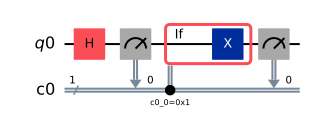

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)):
    circuit.x(q0)
circuit.measure(q0, c0)
circuit.draw("mpl")

# example output counts: {'0': 1024}

The `with` statement can be given an assignment target which is itself a context manager that can be stored and subsequently used to create an else block, which is executed whenever the contents of the `if` block are *not* executed.

In the example below, we initialize registers with two qubits and two classical bits. We apply a Hadamard gate to the first qubit and measure it. If the result is 1, then we apply a Hadamard gate on the second qubit; otherwise, we apply an X gate on the second qubit. Finally, we measure the second qubit as well.

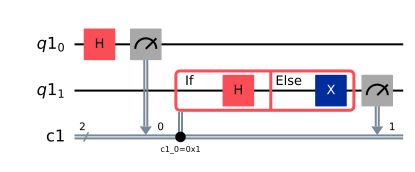

In [2]:
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as else_:
    circuit.h(q1)
with else_:
    circuit.x(q1)
circuit.measure(q1, c1)

circuit.draw("mpl")

# example output counts: {'01': 260, '11': 272, '10': 492}

In addition to conditioning on a single classical bit, it's also possible to condition on the value of a classical register composed of multiple bits.

In the example below, we apply Hadamard gates to two qubits and measure them. If the result is `01`, that is, the first qubit is 1 and the second qubit is 0, then we apply an X gate to a third qubit. Finally, we measure the third qubit. Note that for clarity, we chose to specify the state of the third classical bit, which is 0, in the `if` condition. In the circuit drawing, the condition is indicated by the circles on the classical bits being conditioned on. A black circle indicates conditioning on 1, while a white circle indicates conditioning on 0.

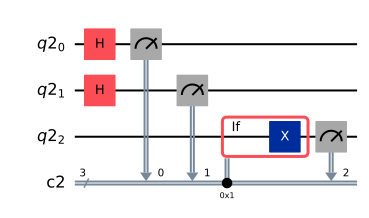

In [3]:
qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.if_test((clbits, 0b001)):
    circuit.x(q2)
circuit.measure(q2, c2)

circuit.draw("mpl")

# example output counts: {'101': 269, '011': 260, '000': 252, '010': 243}

## Classical expressions

The Qiskit classical expression module [`qiskit.circuit.classical`](/docs/api/qiskit/circuit_classical) contains an exploratory representation of runtime operations on classical values during circuit execution. Due to hardware limitations, only `QuantumCircuit.if_test()`  conditions are currently supported.

The following example shows that you can use the calculation of the parity to create an n-qubit GHZ state using dynamic circuits. First, generate $n/2$ Bell pairs on adjacent qubits. Then, glue these pairs together using a layer of CNOT gates in between pairs. You then measure the target qubit of all prior CNOT gates and reset each measured qubit to the state $\vert 0 \rangle$. You apply $X$ to every unmeasured site for which the parity of all preceding bits is odd. Finally, CNOT gates are applied to the measured qubits to re-establish the entanglement lost in the measurement.


In the parity calculation, the first element of the constructed expression involves lifting the Python object `mr[0]`to a [`Value`](/docs/api/qiskit/circuit_classical#value)  node. This is not necessary for `mr[1]` and the possible following classical register, as they are inputs to `expr.bit_xor`, and any necessary lifting is done automatically in these cases. Such expressions can be built up in loops and other constructs.

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

num_qubits = 8
if num_qubits % 2 or num_qubits < 4:
    raise ValueError("num_qubits must be an even integer ≥ 4")
meas_qubits = list(range(2, num_qubits, 2))  # qubits to measure and reset

qr = QuantumRegister(num_qubits, "qr")
mr = ClassicalRegister(len(meas_qubits), "m")
qc = QuantumCircuit(qr, mr)

# Create local Bell pairs
qc.reset(qr)
qc.h(qr[::2])
for ctrl in range(0, num_qubits, 2):
    qc.cx(qr[ctrl], qr[ctrl + 1])

# Glue neighboring pairs
for ctrl in range(1, num_qubits - 1, 2):
    qc.cx(qr[ctrl], qr[ctrl + 1])

# Measure boundary qubits between pairs,reset to 0
for k, q in enumerate(meas_qubits):
    qc.measure(qr[q], mr[k])
    qc.reset(qr[q])

# Parity-conditioned X corrections
# Each non-measured qubit gets flipped iff the parity (XOR) of all
# preceding measurement bits is 1
for tgt in range(num_qubits):
    if tgt in meas_qubits:  # skip measured qubits
        continue
    # all measurement registers whose physical qubit index < tgt
    left_bits = [k for k, q in enumerate(meas_qubits) if q < tgt]
    if not left_bits:  # skip if list empty
        continue

    # build XOR-parity expression
    parity = expr.lift(mr[left_bits[0]])  # lift the first bit to Value
    for k in left_bits[1:]:
        parity = expr.bit_xor(
            mr[k], parity
        )  # calculate parity with all other bits
    with qc.if_test(parity):  # Add X if parity is 1
        qc.x(qr[tgt])

# Re-entangle measured qubits
for ctrl in range(1, num_qubits - 1, 2):
    qc.cx(qr[ctrl], qr[ctrl + 1])

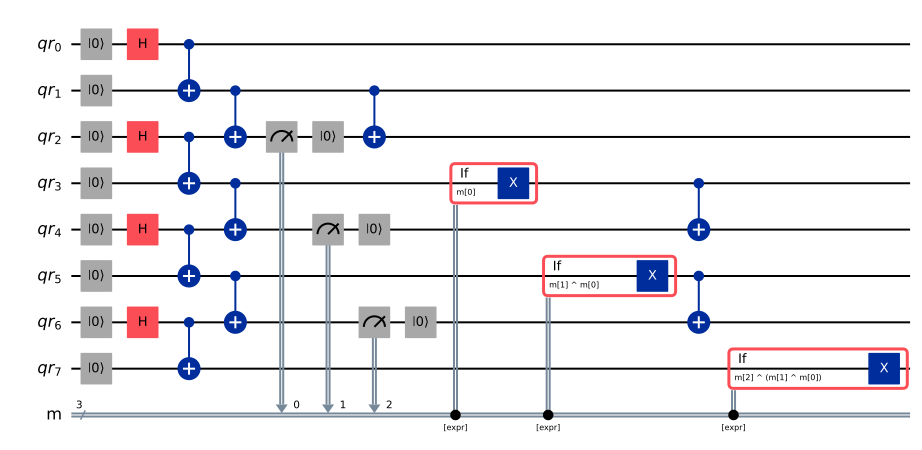

In [5]:
qc.draw(output="mpl", style="iqp", idle_wires=False, fold=-1)

## Qiskit Runtime limitations

Be aware of the following constraints when running dynamic circuits in Qiskit Runtime.  Note that as new features and improvements are added throughout 2025, some of these limitations will be lifted.

- Due to the limited physical memory on control electronics, there is also a limit on the number of `if` statements and size of their operands. This limit is a function of the number of broadcasts and the number of broadcasted bits in a job (not a circuit).

   When processing an `if` condition, measurement data needs to be transferred to the control logic to make that evaluation. A broadcast is a transfer of unique classical data, and broadcasted bits is the number of classical bits being transferred. Consider the following:

   ```python
   c0 = ClassicalRegister(3)
   c1 = ClassicalRegister(5)
   ...
   with circuit.if_test((c0, 1)) ...
   with circuit.if_test((c0, 3)) ...
   with circuit.if_test((c1[2], 1)) ...
   ```
   In the previous code example, the first two `if_test`s on `c0` are considered one broadcast because the content of `c0` did not change, and thus does not need to be re-broadcasted. The `if_test` on `c1` is a second broadcast. The first one broadcasts all three bits in `c0` and the second broadcasts just one bit, making a total of four broadcasted bits.

   Currently, if you broadcast 60 bits each time, then the job can have approximately 300 broadcasts. If you broadcast just one bit each time, however, then the job can have 2400 broadcasts.
- Limitations on classical registers:
      - The operand used in an `if_test` statement must be 32 or fewer bits. Thus, if you are comparing an entire `ClassicalRegister`, the size of that `ClassicalRegister` must be 32 or fewer bits. If you are comparing just a single bit from a `ClassicalRegister`, however, that `ClassicalRegister` can be of any size (since the operand is only one bit).

         For example, the "invalid" code block does not work because `cr` is more than 32 bits.  You can, however, use a classical register wider than 32 bits if you are testing only one bit, as shown in the "valid" code block.

         <Tabs>
         <TabItem value="Invalid" label="Invalid">
            ```python
               cr = ClassicalRegister(50)
               qr = QuantumRegister(50)
               circuit = QuantumCircuit(qr, cr)
               ...
               circ.measure(qr, cr)
               with circ.if_test((cr, 15)):
                  ...
            ```
         </TabItem>
         <TabItem value="Valid" label="Valid">
            ```python
               cr = ClassicalRegister(50)
               qr = QuantumRegister(50)
               circuit = QuantumCircuit(qr, cr)
               ...
               circ.measure(qr, cr)
               with circ.if_test((cr[5], 1)):
                  ...
            ```
         </TabItem>
         </Tabs>
      -  Qiskit Runtime cannot _broadcast_ (a bit is broadcasted if it's used in an `if_test` statement) more than 60 bits at a time. You can explicitly ensure that you are working with different broadcasts by adding barriers.

         <Tabs>
         <TabItem value="Invalid" label="Invalid">
            The following code block does not work because it contains 64 broadcasted bits:
                  ```python
                     cr1 = ClassicalRegister(32)
                     cr2 = ClassicalRegister(32)
                     qr = QuantumRegister(64)
                     circuit = QuantumCircuit(qr, cr1, cr2)
                     ...
                     circ.measure(qr[0:32], cr1)
                     circ.measure(qr[32:], cr2)
                     with circ.if_test((cr1, 32)):  # 32 bits are broadcasted here
                     ...
                     with circ.if_test((cr2, 32)):  # Another 32 bits are broadcasted here, exceeding the limit!
                        ...
                  ```
         </TabItem>
         <TabItem value="Valid" label="Valid">
            ```python
               cr1 = ClassicalRegister(32)
               cr2 = ClassicalRegister(32)
               qr = QuantumRegister(64)
               ...
               circ.measure(qr[0:32], cr1)
               with circ.if_test((cr1, 32)):
                  ...
               circ.barrier()
               circ.measure(qr[32:], cr2)
               with circ.if_test((cr2, 32)):
                  ...
            ```
         </TabItem>
         </Tabs>

- Nested conditionals are not allowed. For example, the following code block will not work because it has an `if_test` inside another `if_test`:
   <Tabs>
    <TabItem value="Invalid" label="Invalid">
        ```python
           c1 = ClassicalRegister(1, "c1")
           c2 = ClassicalRegister(2, "c2")
           ...
           with circ.if_test((c1, 1)):
            with circ.if_test(c2, 1)):
             ...
        ```
     </TabItem>
     <TabItem value="Valid" label="Valid">
        ```python
        cr = ClassicalRegister(2)
        ...
        with circuit.if_test((cr, 0b11)):
          ...
        ```
     </TabItem>
    </Tabs>

- Having `reset` or measurements inside conditionals is not supported.
- Arithmetic operations are not supported.
- See the [OpenQASM 3 feature table](/docs/guides/qasm-feature-table) to determine which OpenQASM 3 features are supported on Qiskit and Qiskit Runtime.
- When OpenQASM 3 (instead of `QuantumCircuit`) is used as the input format to pass circuits to Qiskit Runtime primitives, only instructions that can be loaded into Qiskit are supported. Classical operations, for example, are not supported because they cannot be loaded into Qiskit. See [Import an OpenQASM 3 program into Qiskit](/docs/guides/interoperate-qiskit-qasm3#import-an-openqasm-3-program-into-qiskit) for more information on loading an OpenQASM 3 program into Qiskit.

## Next steps

<Admonition type="tip" title="Recommendations">
- Learn about [Deferred timing resolution using stretch.](/docs/guides/stretch)
- Review the [circuit library API](/docs/api/qiskit/circuit_library) reference.
</Admonition>